In [1]:
!pip install --pre --upgrade mxnet-cu90
!pip install gluoncv
!pip install gluonnlp
!pip install spacy
!pip install seaborn

    100% |████████████████████████████████| 400.0MB 182kB/s eta 0:00:01    37% |████████████                    | 149.8MB 47.1MB/s eta 0:00:06    63% |████████████████████▏           | 252.5MB 48.7MB/s eta 0:00:04    91% |█████████████████████████████▏  | 364.8MB 54.5MB/s eta 0:00:01
Requirement not upgraded as not directly required: requests<2.19.0,>=2.18.4 in /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu90) (2.18.4)
Requirement not upgraded as not directly required: graphviz<0.9.0,>=0.8.1 in /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu90) (0.8.1)
Requirement not upgraded as not directly required: numpy<1.15.0,>=1.8.2 in /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu90) (1.13.3)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from requests<2.19.0,>=2.18.4->mxnet-cu90) (3.0.4)
Requirement 

mxnet-model-server 0.3 requires fasteners, which is not installed.
mxnet-model-server 0.3 requires importlib2, which is not installed.
mxnet-model-server 0.3 requires mxnet>=1.1, which is not installed.
mxnet-model-server 0.3 requires onnx-mxnet>=0.4.2, which is not installed.
mxnet-model-server 0.3 requires fasteners, which is not installed.
mxnet-model-server 0.3 requires importlib2, which is not installed.
mxnet-model-server 0.3 requires mxnet>=1.1, which is not installed.
mxnet-model-server 0.3 requires onnx-mxnet>=0.4.2, which is not installed.


# Checking MXNet version after upgrade

In [2]:
import mxnet as mx
mx.__version__

'1.3.0'

# An introduction to GluonNLP 

## Objectives:
- A quick introduction to GluonNLP and what it is for
- Pre-processing IMDB dataset for a Sentiment Analysis Task
- Training a sentiment analysis model on IMDB database

# GluonNLP

GluonNLP is a toolkit that enables 
- easy text preprocessing, 
- datasets loading and 
- neural models building to help you speed up your Natural Language Processing (NLP) research.

## Features
1. Training scripts to reproduce SOTA results reported in research papers.
2. Pre-trained models for common NLP tasks.
3. Carefully designed APIs that greatly reduce the implementation complexity.
4. Community support.

## Installation
`$pip install mxnet[-cu-x] --pre --upgrade --user`

`$pip install gluonnlp --pre --upgrade --user`



# Import statemetns

In [2]:
from mxnet import gluon
import gluonnlp as nlp
import time
import multiprocessing as mp
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Downloading IMDB Data Set & Instansiating SimpleDataSet Objects

- IMDB dataset includes 50000 movie reviews.
- the split between positive and negative is 50/50
- Any score $\geq 7$ is considered positive
- Any score $\leq 4$ is considered negative
- the dataset has removed all reviews with scrored in [5,6]

In [3]:
from numpy.random import randint
train_dataset = nlp.data.IMDB(segment='train', root='../data/')
test_dataset = nlp.data.IMDB(segment='test', root='../data/')
for i in range(5):
    k = randint(1, 2000)
    print(train_dataset[k][0][:randint(200)])
    print("SENTIMENT_SCORE: [{}]\n'".format(train_dataset[k][1]))

This one is tough to watch -- as an earlier reviewer says. That is amazing considering the terrible films that came out right after WWII -- particularly the "liberation" of Dachau. I
SENTIMENT_SCORE: [8]
'
The first and second seasons started off shakily, with good episodes sandwiched in between average ones, and at times resorting to clichéd 
SENTIMENT_SCORE: [10]
'
In Manhattan, the American middle class Jim Blandings (Cary Grant) lives with his wife Muriel (Myrna Loy) and two teenage daughters in a four bedr
SENTIMENT_SCORE: [8]
'
A friend of mine recommended this movie, citing my vocal and inflective similarities with Des Howl, the movie's main character. I guess to an extent I can see that and p
SENTIMENT_SCORE: [8]
'
Actually my vote is a 7.5. Anyway, the movie was good, it has those funny parts that make it deserve to see it, don't misunderstand me, is not the funniest movie of the world, and its 
SENTIMENT_SCORE: [7]
'


# SimpleDataset Class Hierarchy

In [4]:
print(nlp.data.IMDB.__bases__)
print(gluon.data.SimpleDataset.__bases__)

(<class 'mxnet.gluon.data.dataset.SimpleDataset'>,)
(<class 'mxnet.gluon.data.dataset.Dataset'>,)



# Setting Max Seq Length & Defining Tokenizer

In [5]:
length_clip = nlp.data.ClipSequence(500)
tokenizer = nlp.data.SpacyTokenizer('en')

# Pre-processing Data

- `preprocess(x)` 
 - normalized label to 1 for positive and 0 for negative
 - tokenized data
 - clips the length
 - returns tokenized data and label

- `preprocess_dataset` uses paralele processing using maximum number of CPUs to
 - run `preprocess`, and
 - calculate length of each sentence

In [6]:
# Dataset preprocessing
def preprocess(x):
    data = x[0]
    label = x[1]
    label = int(label > 5)
    data = length_clip(tokenizer(data))
    return data, label

def get_length(x):
    return float(len(x[0]))

def preprocess_dataset(dataset):
    start = time.time()
    pool = mp.Pool()
    dataset = gluon.data.SimpleDataset(pool.map(preprocess, dataset))
    lengths = gluon.data.SimpleDataset(pool.map(get_length, dataset))
    end = time.time()
    print('Done! Tokenizing Time={:.2f}s, #Sentences={}'.format(end - start, len(dataset)))
    return dataset, lengths

# Preprocess the dataset
train_dataset, train_data_lengths = preprocess_dataset(train_dataset)
test_dataset, test_data_lengths = preprocess_dataset(test_dataset)



Done! Tokenizing Time=4.84s, #Sentences=25000
Done! Tokenizing Time=5.04s, #Sentences=25000


# Creating Vocabulary

In [7]:
train_seqs = [sample[0] for sample in train_dataset]
counter = nlp.data.count_tokens(list(itertools.chain.from_iterable(train_seqs)))
vocab = nlp.Vocab(counter=counter, max_size=10000, padding_token=None, eos_token=None, bos_token=None)
train_seqs[0]


['Bromwell',
 'High',
 'is',
 'a',
 'cartoon',
 'comedy',
 '.',
 'It',
 'ran',
 'at',
 'the',
 'same',
 'time',
 'as',
 'some',
 'other',
 'programs',
 'about',
 'school',
 'life',
 ',',
 'such',
 'as',
 '"',
 'Teachers',
 '"',
 '.',
 'My',
 '35',
 'years',
 'in',
 'the',
 'teaching',
 'profession',
 'lead',
 'me',
 'to',
 'believe',
 'that',
 'Bromwell',
 'High',
 "'s",
 'satire',
 'is',
 'much',
 'closer',
 'to',
 'reality',
 'than',
 'is',
 '"',
 'Teachers',
 '"',
 '.',
 'The',
 'scramble',
 'to',
 'survive',
 'financially',
 ',',
 'the',
 'insightful',
 'students',
 'who',
 'can',
 'see',
 'right',
 'through',
 'their',
 'pathetic',
 'teachers',
 "'",
 'pomp',
 ',',
 'the',
 'pettiness',
 'of',
 'the',
 'whole',
 'situation',
 ',',
 'all',
 'remind',
 'me',
 'of',
 'the',
 'schools',
 'I',
 'knew',
 'and',
 'their',
 'students',
 '.',
 'When',
 'I',
 'saw',
 'the',
 'episode',
 'in',
 'which',
 'a',
 'student',
 'repeatedly',
 'tried',
 'to',
 'burn',
 'down',
 'the',
 'school',
 '

In [8]:
vocab[train_dataset[0][0]]

[0,
 2012,
 8,
 4,
 1116,
 231,
 3,
 51,
 2311,
 40,
 1,
 188,
 67,
 20,
 59,
 97,
 6190,
 49,
 422,
 133,
 2,
 160,
 20,
 13,
 0,
 13,
 3,
 374,
 5063,
 174,
 9,
 1,
 5390,
 6674,
 498,
 83,
 7,
 282,
 12,
 0,
 2012,
 15,
 2042,
 8,
 88,
 2661,
 7,
 714,
 87,
 8,
 13,
 0,
 13,
 3,
 24,
 0,
 7,
 2149,
 0,
 2,
 1,
 6661,
 1519,
 43,
 68,
 78,
 234,
 163,
 79,
 1286,
 5847,
 53,
 0,
 2,
 1,
 0,
 6,
 1,
 241,
 959,
 2,
 41,
 3276,
 83,
 6,
 1,
 6964,
 10,
 689,
 5,
 79,
 1519,
 3,
 312,
 10,
 220,
 1,
 412,
 9,
 73,
 4,
 1464,
 3900,
 836,
 7,
 3936,
 212,
 1,
 422,
 2,
 10,
 1304,
 0,
 0,
 40,
 0,
 2012,
 3,
 145,
 381,
 384,
 90,
 0,
 90,
 10,
 169,
 162,
 7,
 9373,
 36,
 6,
 148,
 5847,
 3,
 0,
 90,
 9491,
 7,
 0,
 2012,
 3,
 10,
 561,
 12,
 130,
 1528,
 6,
 82,
 641,
 118,
 12,
 0,
 2012,
 8,
 259,
 4345,
 3,
 257,
 4,
 2546,
 12,
 11,
 8,
 29,
 38]

# Vectorizing Data

In [9]:
def t2i(x):
    return vocab[x[0]], x[1]

pool = mp.Pool()
train_dataset = pool.map(t2i, train_dataset)
test_dataset = pool.map(t2i, test_dataset)
pool.close()

In [10]:

print(train_dataset[0][0][:200])

[0, 2012, 8, 4, 1116, 231, 3, 51, 2311, 40, 1, 188, 67, 20, 59, 97, 6190, 49, 422, 133, 2, 160, 20, 13, 0, 13, 3, 374, 5063, 174, 9, 1, 5390, 6674, 498, 83, 7, 282, 12, 0, 2012, 15, 2042, 8, 88, 2661, 7, 714, 87, 8, 13, 0, 13, 3, 24, 0, 7, 2149, 0, 2, 1, 6661, 1519, 43, 68, 78, 234, 163, 79, 1286, 5847, 53, 0, 2, 1, 0, 6, 1, 241, 959, 2, 41, 3276, 83, 6, 1, 6964, 10, 689, 5, 79, 1519, 3, 312, 10, 220, 1, 412, 9, 73, 4, 1464, 3900, 836, 7, 3936, 212, 1, 422, 2, 10, 1304, 0, 0, 40, 0, 2012, 3, 145, 381, 384, 90, 0, 90, 10, 169, 162, 7, 9373, 36, 6, 148, 5847, 3, 0, 90, 9491, 7, 0, 2012, 3, 10, 561, 12, 130, 1528, 6, 82, 641, 118, 12, 0, 2012, 8, 259, 4345, 3, 257, 4, 2546, 12, 11, 8, 29, 38]


# Creating DataLoader

In [11]:
batch_size = 100
train_data_loader = gluon.data.DataLoader(dataset=train_dataset,
                                          shuffle=True, 
                                          batch_size=batch_size, 
                                          last_batch='rollover')
test_data_loader = gluon.data.DataLoader(dataset=test_dataset, 
                                         shuffle=False,
                                         batch_size=batch_size, 
                                         last_batch='rollover')


# Distribution of Data

Aerage Sentence Length: 246.4104;
Stentence Length Standard Diviation: 133.41041777852283


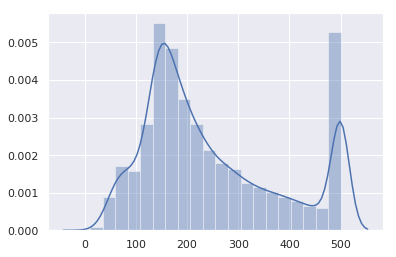

In [12]:
sns.set(color_codes=True)
sns.distplot(train_data_lengths[:], bins=20, hist=True, rug=False)
print("Aerage Sentence Length: {};\nStentence Length Standard Diviation: {}".format(np.average(train_data_lengths[:]),
                                                                                 np.std(train_data_lengths[:])
                                                                                 ))
                                                                                

# Batchify
- A  we need to have fixed size sequence lenght, we attempt to batchify data sequences so that:
 - Eequence lenghts are equal
 - Empty spaces are padded 

In [18]:
from gluonnlp.data import batchify as bf
batcify_fn = bf.Tuple(bf.Pad(axis=0), bf.Stack())

In [19]:
a = ([1,2,3], 0)
b = ([4,5], 1)
c = ([6,7,8,9,10,11,12,13], 1)
batcify_fn([a,b,c])

(
 [[ 1  2  3  0  0  0  0  0]
  [ 4  5  0  0  0  0  0  0]
  [ 6  7  8  9 10 11 12 13]]
 <NDArray 3x8 @cpu_shared(0)>, 
 [0 1 1]
 <NDArray 3 @cpu_shared(0)>)

# Bucketing
- The naive solution is to pad all sentences to maximum sequence lenght.
- From the distribution diagram we can remember that majority of the sentence length were about 150-250 in lenght
- Padding all sentences to 500 is massively inefficinet.
- We solve this problem through buckeitng by creating classes of buckets of fixed length.
 - For example we can put sentences of length under 50 in one bucket, 50-100 in a second bucket, ... 

In [15]:
batch_sampler = nlp.data.sampler.FixedBucketSampler(train_data_lengths, 
                                                    batch_size=100, 
                                                    num_buckets=20, 
                                                    shuffle=True)
print(batch_sampler.stats())

FixedBucketSampler:
  sample_num=25000, batch_num=261
  key=[44, 68, 92, 116, 140, 164, 188, 212, 236, 260, 284, 308, 332, 356, 380, 404, 428, 452, 476, 500]
  cnt=[139, 842, 955, 1003, 2278, 3408, 2585, 2029, 1559, 1254, 1075, 925, 766, 645, 605, 524, 468, 376, 354, 3210]
  batch_size=[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


# Redefining `train_data_loader`

In [16]:
train_data_loader = gluon.data.DataLoader(train_dataset, batch_sampler=batch_sampler, batchify_fn=batcify_fn)

# Scaling Batch Sizes
- Fot futher efficiency we can scale the batches, so smaller buckets will have larget batch sizes.
- This is achieved through ratio. $ratio \geq 0$ scales up batch sizes.

In [20]:
batch_sampler = nlp.data.sampler.FixedBucketSampler(train_data_lengths, 
                                                    batch_size=100, 
                                                    num_buckets=20, 
                                                    shuffle=True,
                                                    ratio=.5)
print(batch_sampler.stats())

FixedBucketSampler:
  sample_num=25000, batch_num=210
  key=[44, 68, 92, 116, 140, 164, 188, 212, 236, 260, 284, 308, 332, 356, 380, 404, 428, 452, 476, 500]
  cnt=[139, 842, 955, 1003, 2278, 3408, 2585, 2029, 1559, 1254, 1075, 925, 766, 645, 605, 524, 468, 376, 354, 3210]
  batch_size=[568, 367, 271, 215, 178, 152, 132, 117, 105, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


# Redefining `train_data_loader`

In [21]:
train_data_loader = gluon.data.DataLoader(train_dataset, 
                                          batch_sampler=batch_sampler, 
                                          batchify_fn=batcify_fn)
test_data_loader = gluon.data.DataLoader(test_dataset, 
                                         batch_sampler=batch_sampler, 
                                         batchify_fn=batcify_fn, 
                                         shuffle=False)

# Recap

1. Loading the data using `gluon.nlp.data.IMDB`: This returns a `gluon.data.Dataset.SimpleDataSet` object
2. Creating a padding strategy using `batchify_fn` in order to create a tensor of fixed length that can be used in tensor operations.
3. Creating a bucketing strategy in order to reduce inefficient padding using `lp.data.sampler.FixedBucketSampler`
4. creating data iterators for training using `batch_sampler` and `batchify_fn`

# We are now ready to build a model
[Next: Sentiment Analysis](SentimentAnalysis.ipynb)